# 1. Tools

#    

In [2]:
# lines starting with '%' are notebook magic functions
%matplotlib notebook
%pylab
#%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

# standard python packages
import numpy as np

# main analysis software
from Xana import Xana
from Xana.Xplot.niceplot import niceplot

# karabo_data for reading AGIPD data
import karabo_data as kd
from karabo_data import RunDirectory, stack_detector_data
from karabo_data.geometry2 import AGIPD_1MGeometry

# for plotting
import matplotlib as mpl
from matplotlib import patches
from matplotlib.colors import LogNorm
from matplotlib.collections import PatchCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable

import dask.array as da
from dask.distributed import Client, progress
from dask_jobqueue import SLURMCluster
from dask.diagnostics import ProgressBar

from lmfit import Model
import pandas as pd
import seaborn as sns

from Xana.misc.progressbar import progress
from time import sleep

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


In [3]:
# shade ring on detector for manual calibration
def shade_wedges(ax, center, radii, alpha=0.6, cmap='inferno',):
    yl = ax.get_ylim()
    wedges = []
    r = radii
    nr = len(r)
        
    # Loop over data points; create box from errors at each point
    clrs = plt.get_cmap(cmap, nr)
    clrs = clrs(np.arange(nr))
    
    for ri in r:
        w = patches.Wedge(center, ri[0], 0, 360 , width=ri[1])
        wedges.append(w)

    # Create patch collection with specified colour/alpha
    pc = PatchCollection(wedges, facecolors=list(clrs), alpha=alpha,
                         edgecolor='k')

    # Add collection to axes
    lims = (ax.get_xlim(), ax.get_ylim())
    ax.add_collection(pc)
    ax.set_xlim(lims[0])
    ax.set_ylim(lims[1])
    
# add nice colorbar to plots
def add_colorbar(ax, im):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    colorbar(im, cax=cax)
    
# function to edit and display the AGIPD geometry in a simple way
def simple_geometry(image, quad_pos, ring_radius, ring_width, r=2000, vmin=None, vmax=None):
    
    geom = AGIPD_1MGeometry.from_quad_positions(quad_pos=quad_pos)
    d, (cy,cx) = geom.position_modules_fast(image)
    img = d

    # plot only the center part of the detector with radius r [pixels]
    dim = img.shape
    x1, x2 = ( max( cx-r, 0 ), min( cx+r, dim[1] ) )
    y1, y2 = ( max( cy-r, 0 ), min( cy+r, dim[0] ) )
    
    fig, ax = plt.subplots(figsize=(8,9))
    ax = gca()
    ax.hlines(cy-y1, cx-x1 - 20, cx-x1 + 20, colors='r', linewidths=1)
    ax.vlines(cx-x1, cy-y1 - 20, cy-y1 + 20, colors='r', linewidths=1)


    img = d[y1:y2,x1:x2]
    im = ax.imshow(img, origin='lower', norm=LogNorm(vmin=vmin, vmax=vmax, clip=1), cmap='jet')
    add_colorbar(ax, im)

    # shade a ring in pixel coordinates for manual alignment
    shade_wedges(ax, (cx-x1,cy-y1), [(ring_radius, ring_width)], alpha=.2)

    plt.tight_layout()

    dist = geom.to_distortion_array()
    
    return (cy,cx), dist, geom

#    

# 2. Load RUN 65

#    

In [4]:
run = kd.RunDirectory('/gpfs/exfel/exp/MID/201922/p002568/proc/r0065')
run.info()

# of trains:    5791
Duration:       0:09:39
First train ID: 586385602
Last train ID:  586391392

16 detector modules (MID_DET_AGIPD1M-1)
  e.g. module MID_DET_AGIPD1M-1 0 : 512 x 128 pixels
  MID_DET_AGIPD1M-1/DET/0CH0:xtdf
  250 frames per train, up to 1447750 frames total

13 instrument sources (excluding detectors):
  - MID_EXP_FASTADC/ADC/DESTEST:channel_0.output
  - MID_EXP_FASTADC/ADC/DESTEST:channel_1.output
  - MID_EXP_FASTADC/ADC/DESTEST:channel_2.output
  - MID_EXP_FASTADC/ADC/DESTEST:channel_3.output
  - MID_EXP_FASTADC/ADC/DESTEST:channel_4.output
  - MID_EXP_FASTADC/ADC/DESTEST:channel_5.output
  - MID_EXP_FASTADC/ADC/DESTEST:channel_6.output
  - MID_EXP_FASTADC/ADC/DESTEST:channel_7.output
  - MID_EXP_FASTADC/ADC/DESTEST:channel_8.output
  - MID_EXP_FASTADC/ADC/DESTEST:channel_9.output
  - MID_SAE_PUMA/MDL/KARABACON:output
  - MID_SAE_PUMA/MDL/PUMA_CONTROL:output
  - SA2_XTD1_XGM/XGM/DOOCS:output

27 control sources:
  - MID_DET_AGIPD1M/CC/MON_0
  - MID_EXP_AGIPD1M/GAUGE

In [6]:
run.all_sources

frozenset({'MID_DET_AGIPD1M-1/DET/0CH0:xtdf',
           'MID_DET_AGIPD1M-1/DET/10CH0:xtdf',
           'MID_DET_AGIPD1M-1/DET/11CH0:xtdf',
           'MID_DET_AGIPD1M-1/DET/12CH0:xtdf',
           'MID_DET_AGIPD1M-1/DET/13CH0:xtdf',
           'MID_DET_AGIPD1M-1/DET/14CH0:xtdf',
           'MID_DET_AGIPD1M-1/DET/15CH0:xtdf',
           'MID_DET_AGIPD1M-1/DET/1CH0:xtdf',
           'MID_DET_AGIPD1M-1/DET/2CH0:xtdf',
           'MID_DET_AGIPD1M-1/DET/3CH0:xtdf',
           'MID_DET_AGIPD1M-1/DET/4CH0:xtdf',
           'MID_DET_AGIPD1M-1/DET/5CH0:xtdf',
           'MID_DET_AGIPD1M-1/DET/6CH0:xtdf',
           'MID_DET_AGIPD1M-1/DET/7CH0:xtdf',
           'MID_DET_AGIPD1M-1/DET/8CH0:xtdf',
           'MID_DET_AGIPD1M-1/DET/9CH0:xtdf',
           'MID_DET_AGIPD1M/CC/MON_0',
           'MID_EXP_AGIPD1M/GAUGE/PG1',
           'MID_EXP_AGIPD1M/PSC/HV',
           'MID_EXP_AGIPD1M/TSENS/H1_T_EXTHOUS',
           'MID_EXP_AGIPD1M/TSENS/H2_T_EXTHOUS',
           'MID_EXP_AGIPD1M/TSENS/Q1_T_BLOCK

#    

# 3. XGM number of pulses

#    

In [26]:
keys = run.keys_for_source('SA2_XTD1_XGM/XGM/DOOCS:output')
keys

NameError: name 'run' is not defined

<IPython.core.display.Javascript object>


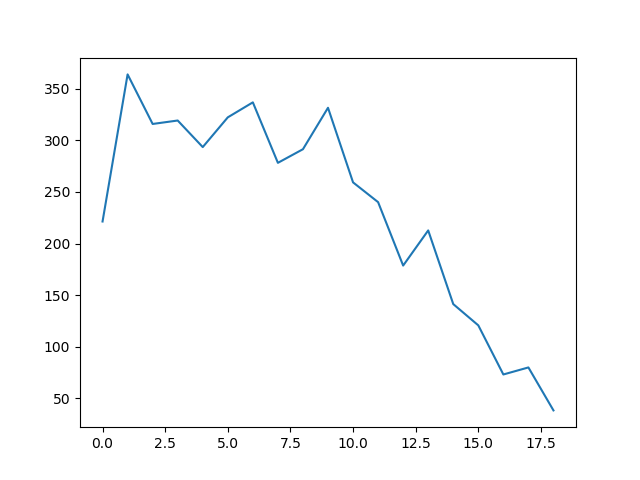

<IPython.core.display.Javascript object>


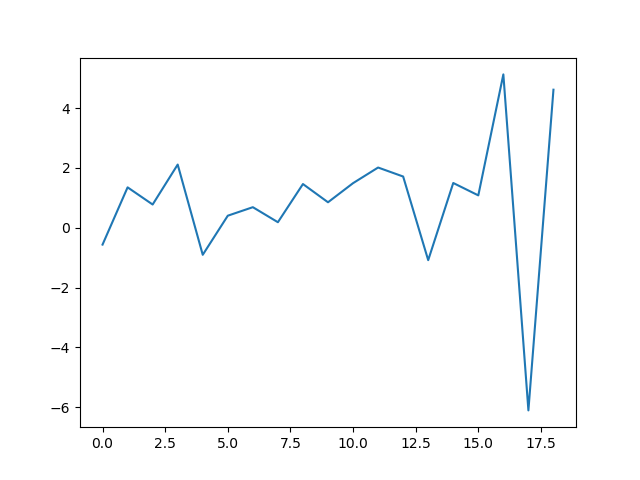

<IPython.core.display.Javascript object>


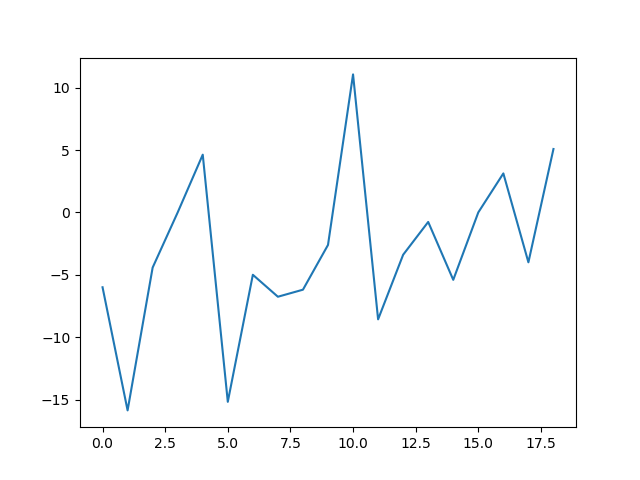

In [4]:
xgm = run.get_array('SA2_XTD1_XGM/XGM/DOOCS:output','data.intensityTD')
train_xgm=run.get_array('SA2_XTD1_XGM/XGM/DOOCS:output','data.trainId')
xgm_x=run.get_array('SA2_XTD1_XGM/XGM/DOOCS:output','data.xTD')
xgm_y=run.get_array('SA2_XTD1_XGM/XGM/DOOCS:output','data.yTD')
figure()
plt.plot(xgm[9,1:20])
figure()
plt.plot(xgm_x[9,1:20])
figure()
plt.plot(xgm_y[9,1:20])

#    

# 4. Full AGIPD - find module with peak

#    

In [151]:
tid

586385607

In [33]:
train_index = 1
tid, train_data = run.select('*/DET/*', 'image.data').train_from_index(train_index)

stacked = kd.stack_detector_data(train_data, 'image.data') # load all pulses of train 200

pulse_index = 1 # select second pulse (index starts with 0)
stacked_pulse = stacked[pulse_index] 

print('stacked shape is', stacked.shape)
print('corresponding to (memory cells, image/gain, module, pix_horz, pix_vert)')
print('\nor for one pulse')
print('stacked_pulse shape is', stacked_pulse.shape)

stacked shape is (250, 16, 512, 128)
corresponding to (memory cells, image/gain, module, pix_horz, pix_vert)

or for one pulse
stacked_pulse shape is (16, 512, 128)


<IPython.core.display.Javascript object>


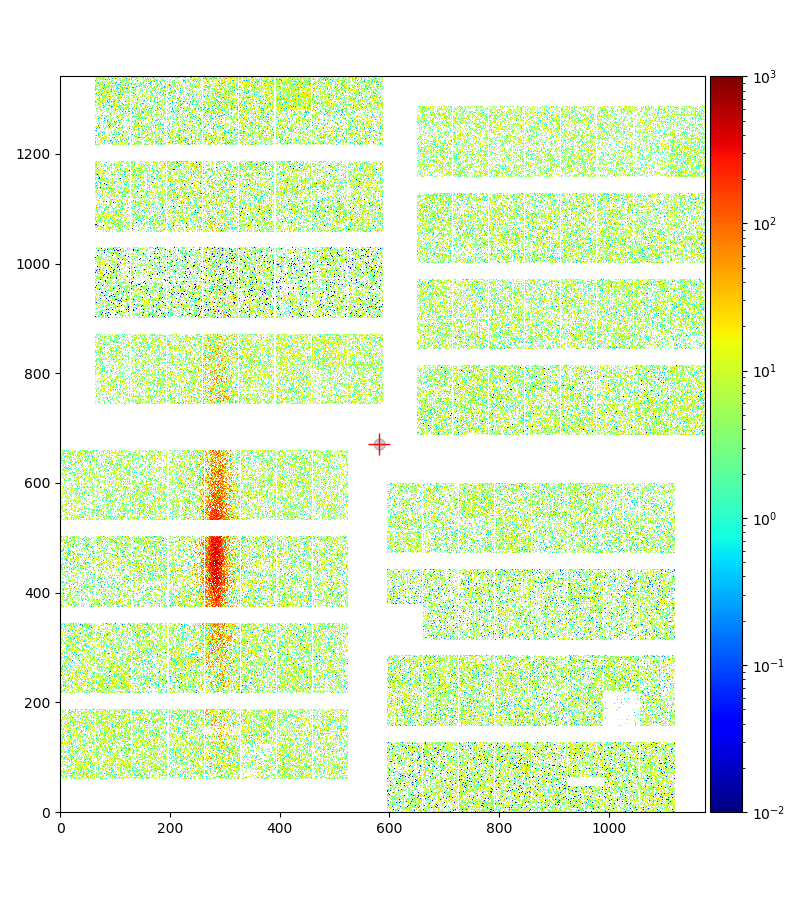

In [34]:
mask = np.load('./agipd_mask_01.npy')
# define corners of quadrants. 

dx = 0
dy = 0
quad_pos = [(-519+dx, 671+dy),
            (-582+dx, -12+dy),
            (540+dx, -200+dy),
            (594+dx, 486+dy)] 

# ring radius and width for shaded area
ring_radius = 10
ring_width = 10

# section of detector to plot 
radial_section = 1000

# stacked_pulse, dark_avr and mask have to be defined/loaded
(cy,cx), dist, geom = simple_geometry(stacked_pulse*mask, quad_pos, ring_radius, ring_width, radial_section,vmin=10e-3,vmax=1000)

#    

# 6. Select data area

#    

/usr/local/lib/python3.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


<IPython.core.display.Javascript object>


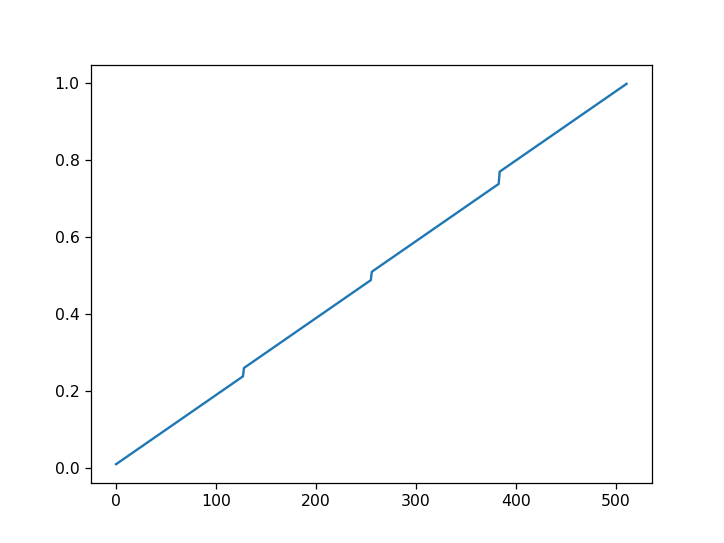

In [153]:
figure()
plot(s)

In [92]:
len(x)

512

In [5]:
y=arange(216,344,1)
y=append(y,arange(373,501,1))
y=append(y,arange(530,658,1))
y=append(y,arange(742,870,1))

In [20]:
x=arange(0,64,1)
x=append(x,arange(66,130,1))
x=append(x,arange(132,196,1))
x=append(x,arange(198,262,1))
x=append(x,arange(264,328,1))
x=append(x,arange(330,394,1))
x=append(x,arange(396,460,1))
x=append(x,arange(462,526,1))

In [7]:
data5=run.get_dask_array('MID_DET_AGIPD1M-1/DET/5CH0:xtdf','image.data').reshape(-1,250,512,128)
data4=run.get_dask_array('MID_DET_AGIPD1M-1/DET/4CH0:xtdf','image.data').reshape(-1,250,512,128)
data6=run.get_dask_array('MID_DET_AGIPD1M-1/DET/6CH0:xtdf','image.data').reshape(-1,250,512,128)
data3=run.get_dask_array('MID_DET_AGIPD1M-1/DET/3CH0:xtdf','image.data').reshape(-1,250,512,128)

trainid3 = run.get_dask_array('MID_DET_AGIPD1M-1/DET/3CH0:xtdf','image.trainId')
trainid4 = run.get_dask_array('MID_DET_AGIPD1M-1/DET/4CH0:xtdf','image.trainId')
trainid5 = run.get_dask_array('MID_DET_AGIPD1M-1/DET/5CH0:xtdf','image.trainId')
trainid6 = run.get_dask_array('MID_DET_AGIPD1M-1/DET/6CH0:xtdf','image.trainId')

In [54]:
data=array(concatenate((data3[1,1:20,170:260,:],data4[1,1:20,230:320,:],data5[1,1:20,230:320,:],data6[1,1:20,230:320,:]),axis=2))

In [51]:
data=array(concatenate((data3[1,1,:,:],data4[1,1,:,:],data5[1,1,:,:],data6[1,1,:,:]),axis=1))

In [21]:
x=x[230:320]

<IPython.core.display.Javascript object>


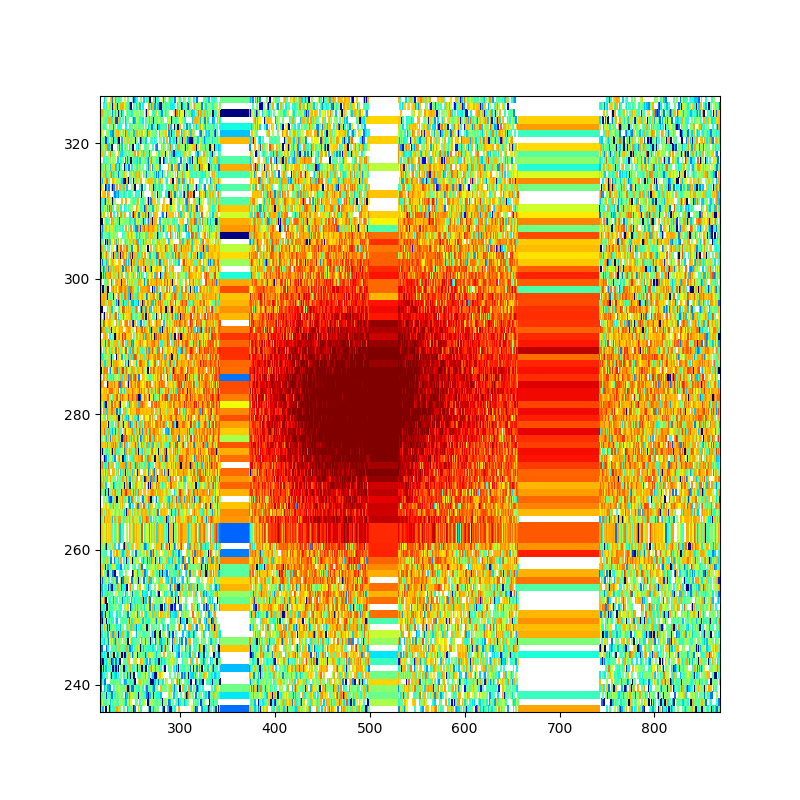

In [55]:
# figure(figsize=(8, 8))
# imshow(data,origin='lower',cmap='jet',norm=mpl.colors.LogNorm(),vmin=10e-2,vmax=1000)

figure( figsize=(8, 8))
pcolormesh(y,x[230:320],fliplr(data[1]),cmap='jet',norm=mpl.colors.LogNorm(),vmin=10e-2,vmax=1000)

In [38]:
for i in range(len(data)):
    data[i,:]=nan_to_num(data[i,:])
    if isnan(data[i,:,:]).any()==True:
        print(True)

/usr/local/lib/python3.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


<IPython.core.display.Javascript object>


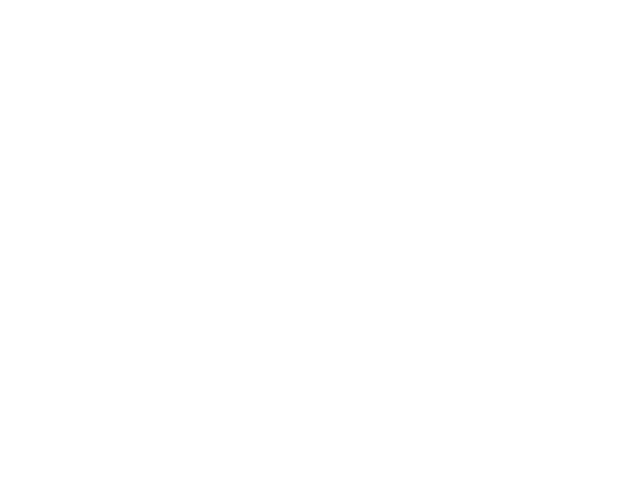

In [58]:
figure()
ion()
for i in range(len(data)):
    plot(x[0,:],sum(data[i,:,:],axis=0))
    pause(0.1)
    gcf().canvas.draw()
    clf()

#    

# 7. Fit linear plots

#    

In [10]:
# data=array(concatenate((data4[606,1:20,230:320,:],data5[606,1:20,230:320,:],data6[606,1:20,230:320,:]),axis=2))

def ft_gaus(x, amp, cen, wid,n):
        return n+amp * np.exp(-(x-cen)**2 /wid) 

model = Model(ft_gaus,independent_vars=['x'])

# values and errors
#params['cen'].value
#params['cen'].stderr

fluct_y=[]
fluct_x=[]


for i in range(len(data)):
    data[i,:,:]=nan_to_num(data[i,:,:])
    Iy=sum(data[i,:,:],axis=0)/90
    Ix=sum(data[i,:,:],axis=1)/512
    fig, ax = subplots(1, 2,figsize=(10,5)) 
    ax.flat[0].plot(y,Iy)
    ax.flat[1].plot(x,Ix)
    
    params_x= model.make_params(amp=max(Ix),cen=mean(x),wid=50,n=5)
    result_x = model.fit(Ix,params_x,x=x)         
    params_x = result_x.params 
    xf = linspace(0,1,90)
    If_x = model.eval(params_x, x=x)

    params_y= model.make_params(amp=max(Iy),cen=mean(y),wid=50,n=2)
    result_y = model.fit(Iy,params_y,x=y)         
    params_y = result_y.params 
    yf = linspace(216,870,900)
    If_y = model.eval(params_y, x=yf)

    ax.flat[1].plot(x,If_x,color='red')
    ax.flat[0].plot(yf,If_y,color='red')
    
    fluct_x.append([params_x['cen'].value,params_x['amp'].value,params_x['wid'].value])
    fluct_y.append([params_y['cen'].value,params_y['amp'].value,params_y['wid'].value])
    
    print(result_x.fit_report())
    print(result_y.fit_report())

fluct_x=array(fluct_x)
fluct_y=array(fluct_y)
fig, ax = subplots(1, 2,figsize=(10,5))
ax.flat[0].plot(fluct_x[:,0])
ax.flat[1].plot(fluct_y[:,0])
fig, ax = subplots(1, 2,figsize=(10,5))
ax.flat[0].plot(fluct_x[:,1])
ax.flat[1].plot(fluct_y[:,1])
fig, ax = subplots(1, 2,figsize=(10,5))
ax.flat[0].plot(fluct_x[:,2])
ax.flat[1].plot(fluct_y[:,2])

NameError: name 'data' is not defined

In [6]:
data_pulse=concatenate((data4[:5767,1:21,230:320,:],data5[:5767,1:21,230:320,:],data6[:5767,1:21,230:320,:]),axis=3)

NameError: name 'data4' is not defined

#    

# 8. Add magnetic data

#    

In [48]:
x=linspace(0,len(correctedData[1]),500000)*18.4*1e-6

1.499786999573999
0.3814430105401882


/usr/local/lib/python3.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


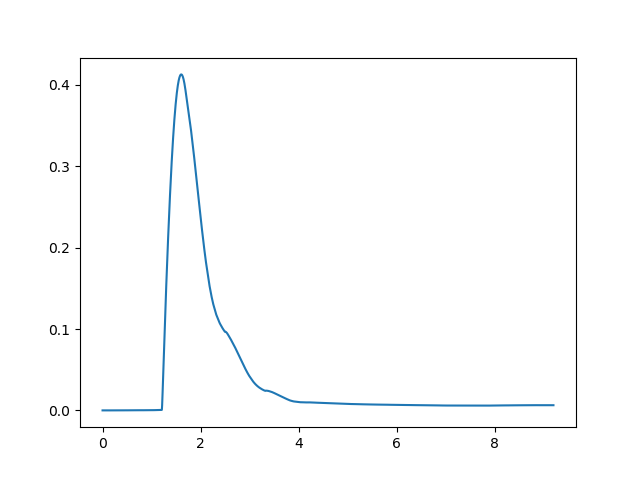

In [97]:
print(x[81510])
B=cumsum(correctedData[1])*18.4*1e-9/2.65/1e-5
print((cumsum(correctedData[1])*18.4*1e-9/2.65/1e-5)[81522])
figure()
plot(x,cumsum(correctedData[1])*18.4*1e-9/2.65/1e-5)

In [69]:
argwhere(x>1.5)

array([[ 81522],
       [ 81523],
       [ 81524],
       ...,
       [499997],
       [499998],
       [499999]])

0
586386208 586386209 586386211 *
1
586386790 586386791 586386793 *
2
* 586387145 586387147 586387148
3
586387420 586387421 586387423 *
4
586388271 586388272 586388274 *
5
* 586388288 586388290 586388291
6
586388553 586388554 586388556 *
7
586389048 586389049 586389051 *
8
586389337 586389338 586389340 *
9
* 586389622 586389624 586389625
10
* 586389902 586389904 586389906
586389902 586389904 586389906 *
11
* 586390355 586390357 586390359
586390355 586390357 586390359 *
12
* 586390357 586390359 586390361
586390357 586390359 586390361 *
13
586390863 586390864 586390866 *
14
586390884 586390885 586390887 *
15
586391235 586391236 586391238 *


<IPython.core.display.Javascript object>


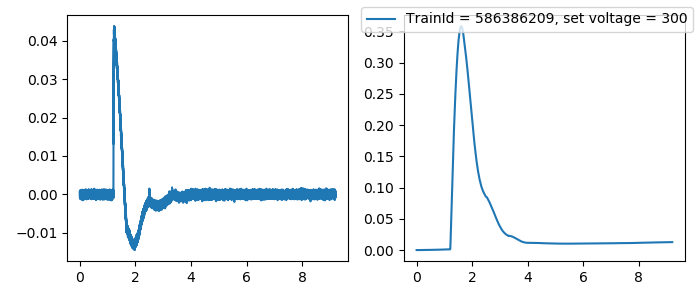

<IPython.core.display.Javascript object>


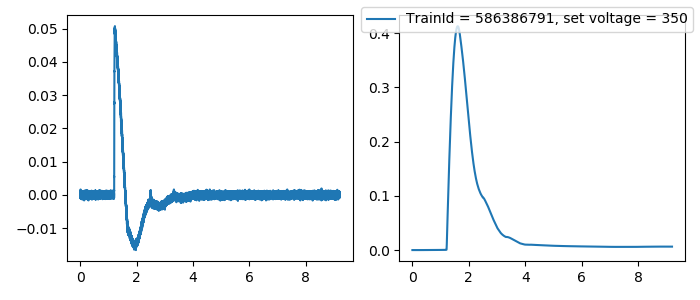

<IPython.core.display.Javascript object>


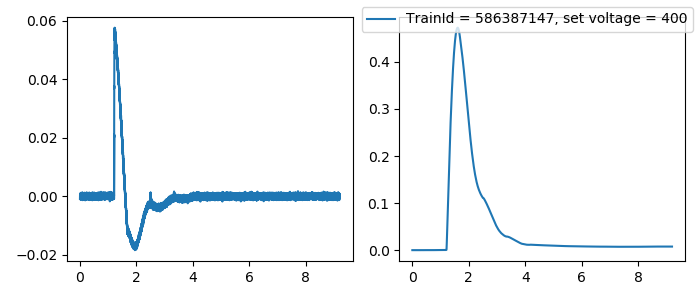

<IPython.core.display.Javascript object>


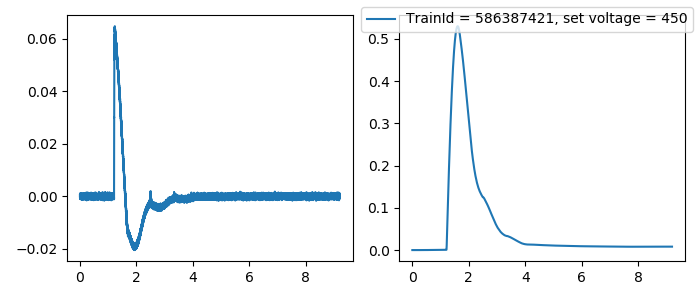

<IPython.core.display.Javascript object>


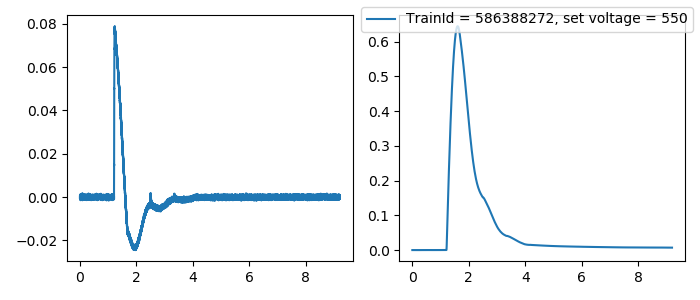

<IPython.core.display.Javascript object>


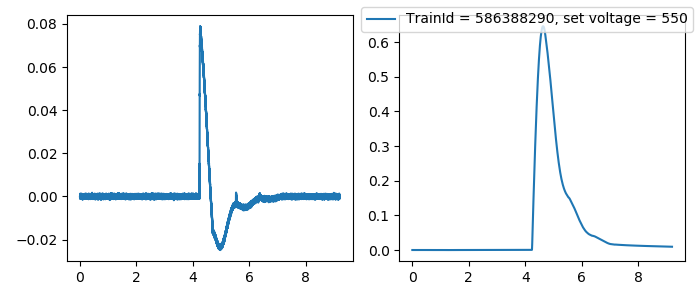

<IPython.core.display.Javascript object>


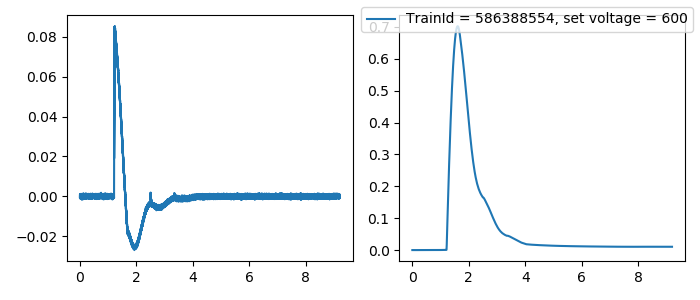

<IPython.core.display.Javascript object>


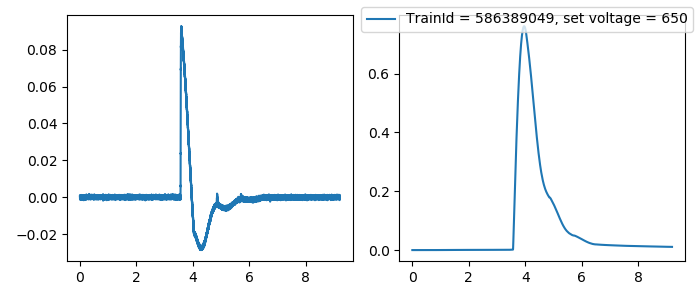

<IPython.core.display.Javascript object>


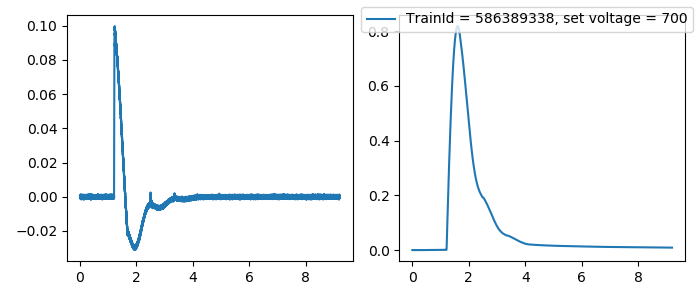

<IPython.core.display.Javascript object>


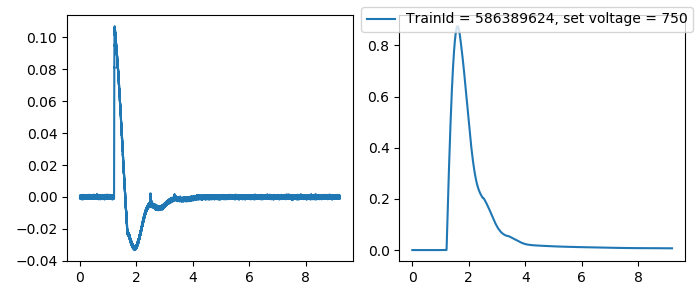

<IPython.core.display.Javascript object>


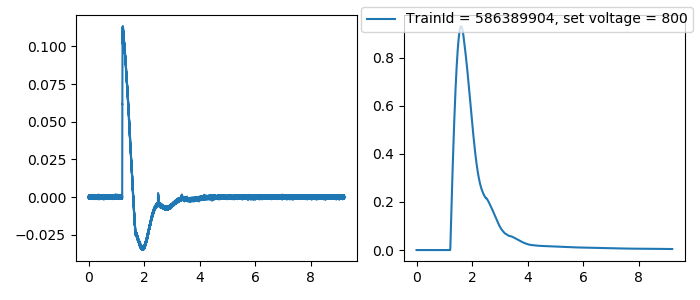

<IPython.core.display.Javascript object>


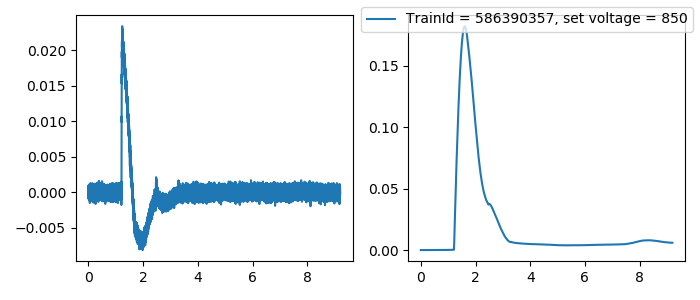

<IPython.core.display.Javascript object>


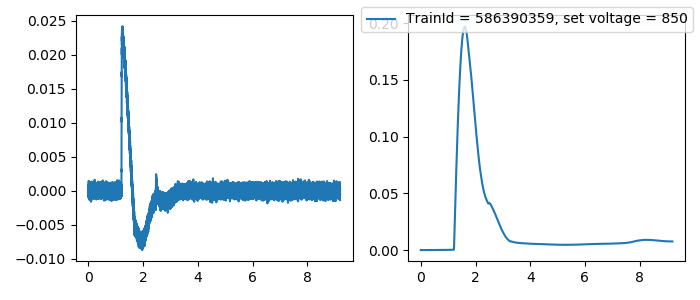

<IPython.core.display.Javascript object>


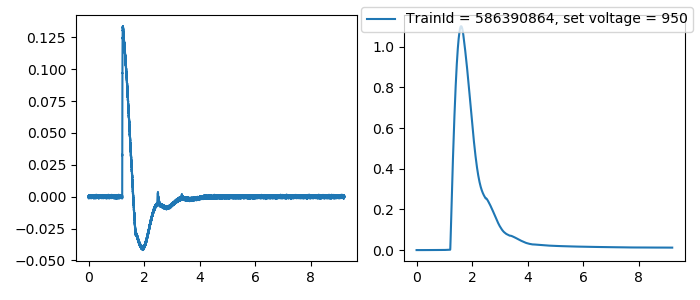

<IPython.core.display.Javascript object>


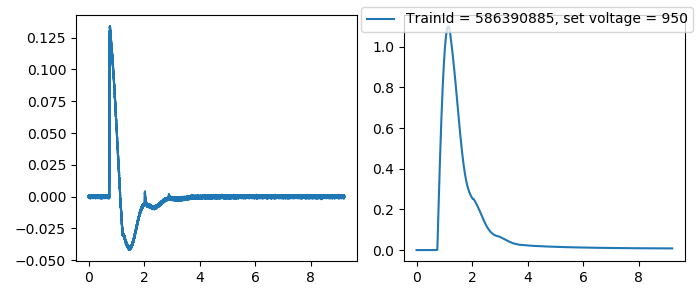

<IPython.core.display.Javascript object>


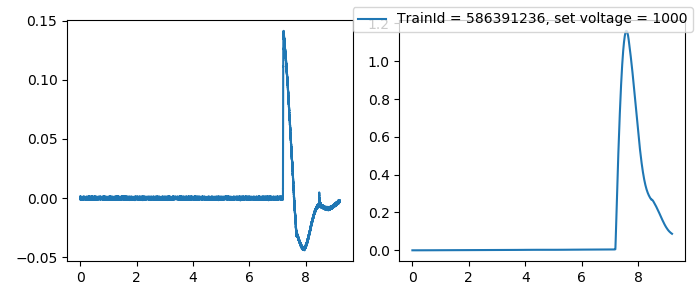

In [9]:
key=f'data.rawData'
raw_data=run.get_array('MID_EXP_FASTADC/ADC/DESTEST:channel_0.output', key)
baseline = run.get_array('MID_EXP_FASTADC/ADC/DESTEST:channel_0.output', key.replace('rawData','baseline'))
TrainId=run.get_array('MID_EXP_FASTADC/ADC/DESTEST:channel_0.output', key.replace('rawData','trainId'))
key = f"voltage.value"
voltage = run.get_array('MID_SAE_PUMA/MDL/PUMA_TEST', key)
x = run.get_array('MID_SAE_PUMA/MDL/PUMA_TEST', key.replace('value','timestamp'))

correctedData=[]
pulse_train=[]
j=0
for i in range(len(raw_data.values)):
    if sum(raw_data.values[i]>baseline.values[i]+400)>0:
        print(j)
        j=j+1
        correctedData.append((raw_data.values[i]-baseline.values[i])/32768.)
        pulse_train.append(TrainId.values[i])
        if (TrainId.values[i]-TrainId.values[i-1]>1):
            print('*',TrainId.values[i-1],TrainId.values[i],TrainId.values[i+1])
        if (TrainId.values[i+1]-TrainId.values[i]>1):
            print(TrainId.values[i-1],TrainId.values[i],TrainId.values[i+1],'*')

x=linspace(0,len(correctedData[1]),500000)*18.4*1e-6
for i in range(len(correctedData)):
    fig, ax = subplots(1, 2, figsize=(7,3))
    ax.flat[0].plot(x,correctedData[i],label='TrainId = {}, set voltage = {}'.format(pulse_train[i],voltage.sel(trainId=pulse_train[i]).values))
    ax.flat[1].plot(x,cumsum(correctedData[i])*18.4*1e-9/2.65/1e-5)
    fig.legend()
    tight_layout()

In [10]:
ion()
for i in sort:
    data=array(concatenate((data3[i,1:20,170:260,:],data4[i,1:20,230:320,:],data5[i,1:20,230:320,:],data6[i,1:20,230:320,:]),axis=2))
    for k in range(len(data)):
        data[k,:,:]=nan_to_num(data[k,:,:])
#         imshow(data[k],origin='lower',cmap='jet',norm=mpl.colors.LogNorm(),aspect='auto',vmin=10e-2,vmax=1000)
        print(trainid3[i*250].compute(),trainid4[i*250].compute(),trainid5[i*250].compute(),trainid6[i*250].compute())
#         gcf().canvas.draw()
#         clf()

TypeError: 'function' object is not iterable

In [13]:
sort[-1]

586391239.0

#    

# 8. Full fit

#    

<IPython.core.display.Javascript object>


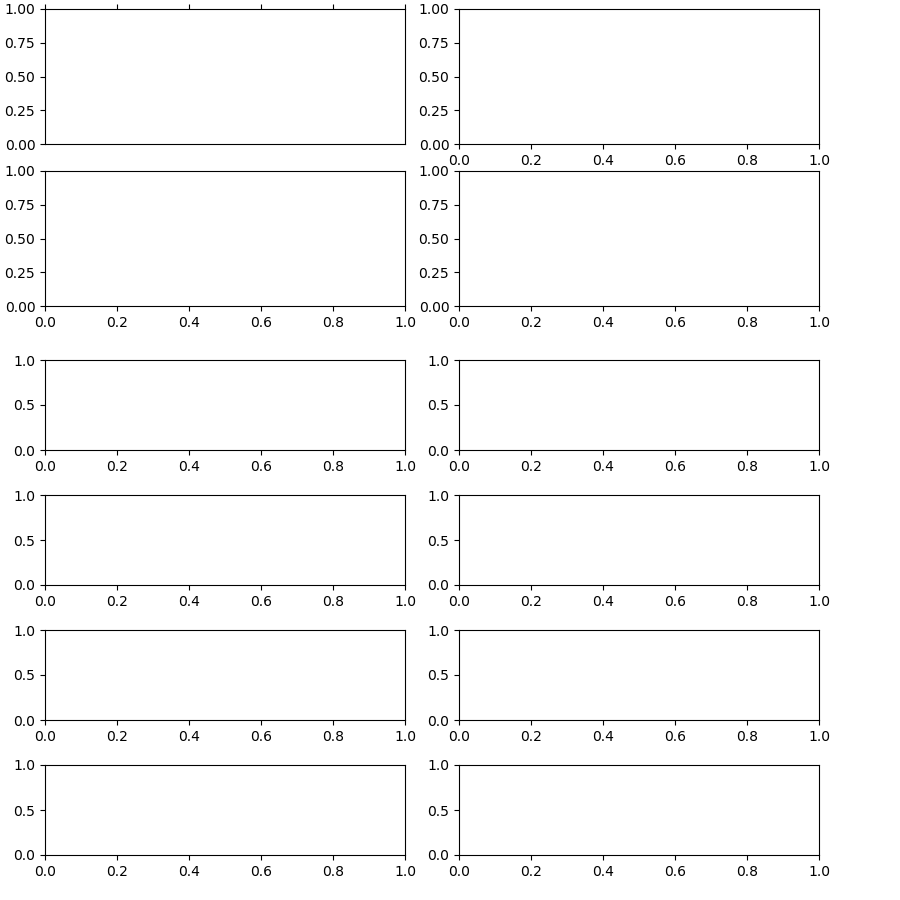

[============================================================] 100.0%
[============================================================] 100.0%
[============================================================] 100.0%


/usr/local/lib/python3.7/site-packages/ipykernel/__main__.py:102: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/usr/local/lib/python3.7/site-packages/ipykernel/__main__.py:130: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


[============================================================] 100.0%
[============================================================] 100.0%
[============================================================] 100.0%
[============================================================] 100.0%
[============================================================] 100.0%
[============================================================] 100.0%
[============================================================] 100.0%


/usr/local/lib/python3.7/site-packages/ipykernel/__main__.py:102: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/usr/local/lib/python3.7/site-packages/ipykernel/__main__.py:130: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


[============================================================] 100.0%
[============================================================] 100.0%
[============================================================] 100.0%
[============================================================] 100.0%
[============================================================] 100.0%
[============================================================] 100.0%
[============================================================] 100.0%


/usr/local/lib/python3.7/site-packages/ipykernel/__main__.py:102: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/usr/local/lib/python3.7/site-packages/ipykernel/__main__.py:130: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


[============================================================] 100.0%
[============================================================] 100.0%
[============================================================] 100.0%
[============================================================] 100.0%
[============================================================] 100.0%
[============================================================] 100.0%
[============================================================] 100.0%


/usr/local/lib/python3.7/site-packages/ipykernel/__main__.py:102: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/usr/local/lib/python3.7/site-packages/ipykernel/__main__.py:130: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


[============================================================] 100.0%
[============================================================] 100.0%
[============================================================] 100.0%
[============================================================] 100.0%
[============================================================] 100.0%
[============================================================] 100.0%
[============================================================] 100.0%


/usr/local/lib/python3.7/site-packages/ipykernel/__main__.py:102: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/usr/local/lib/python3.7/site-packages/ipykernel/__main__.py:130: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


[============================================================] 100.0%
[============================================================] 100.0%
[============================================================] 100.0%
[============================================================] 100.0%
[============================================================] 100.0%
[============================================================] 100.0%
[============================================================] 100.0%


/usr/local/lib/python3.7/site-packages/ipykernel/__main__.py:102: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/usr/local/lib/python3.7/site-packages/ipykernel/__main__.py:130: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


[============================================================] 100.0%
[============================================================] 100.0%
[============================================================] 100.0%
[============================================================] 100.0%
[============================================================] 100.0%
[============================================================] 100.0%
[============================================================] 100.0%


/usr/local/lib/python3.7/site-packages/ipykernel/__main__.py:102: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/usr/local/lib/python3.7/site-packages/ipykernel/__main__.py:130: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


[============================================================] 100.0%
[============================================================] 100.0%
[============================================================] 100.0%
[============================================================] 100.0%
[============================================================] 100.0%
[============================================================] 100.0%
[============================================================] 100.0%


/usr/local/lib/python3.7/site-packages/ipykernel/__main__.py:102: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/usr/local/lib/python3.7/site-packages/ipykernel/__main__.py:130: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


[============================================================] 100.0%
[============================================================] 100.0%
[============================================================] 100.0%
[============================================================] 100.0%
[============================================================] 100.0%
[============================================================] 100.0%
[============================================================] 100.0%


/usr/local/lib/python3.7/site-packages/ipykernel/__main__.py:102: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/usr/local/lib/python3.7/site-packages/ipykernel/__main__.py:130: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


[============================================================] 100.0%
[============================================================] 100.0%
[============================================================] 100.0%
[============================================================] 100.0%
[============================================================] 100.0%
[============================================================] 100.0%
[============================================================] 100.0%


/usr/local/lib/python3.7/site-packages/ipykernel/__main__.py:102: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/usr/local/lib/python3.7/site-packages/ipykernel/__main__.py:130: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


[============================================================] 100.0%
[============================================================] 100.0%
[============================================================] 100.0%
[============================================================] 100.0%
[============================================================] 100.0%
[============================================================] 100.0%
[============================================================] 100.0%


/usr/local/lib/python3.7/site-packages/ipykernel/__main__.py:102: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/usr/local/lib/python3.7/site-packages/ipykernel/__main__.py:130: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


[============================================================] 100.0%
[============================================================] 100.0%


/usr/local/lib/python3.7/site-packages/ipykernel/__main__.py:102: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/usr/local/lib/python3.7/site-packages/ipykernel/__main__.py:130: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


[============================================================] 100.0%
[============================================================] 100.0%
[============================================================] 100.0%


/usr/local/lib/python3.7/site-packages/ipykernel/__main__.py:102: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/usr/local/lib/python3.7/site-packages/ipykernel/__main__.py:130: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


[============================================================] 100.0%
[============================================================] 100.0%


/usr/local/lib/python3.7/site-packages/ipykernel/__main__.py:102: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/usr/local/lib/python3.7/site-packages/ipykernel/__main__.py:130: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


[============================================================] 100.0%
[============================================================] 100.0%
[============================================================] 100.0%
[============================================================] 100.0%
[============================================================] 100.0%
[============================================================] 100.0%
[============================================================] 100.0%


/usr/local/lib/python3.7/site-packages/ipykernel/__main__.py:102: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/usr/local/lib/python3.7/site-packages/ipykernel/__main__.py:130: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


[============================================================] 100.0%
[============================================================] 100.0%
[============================================================] 100.0%
[============================================================] 100.0%
[============================================================] 100.0%
[============================================================] 100.0%
[============================================================] 100.0%


/usr/local/lib/python3.7/site-packages/ipykernel/__main__.py:102: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/usr/local/lib/python3.7/site-packages/ipykernel/__main__.py:130: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


[============================================================] 100.0%
[============================================================] 100.0%
[============================================================] 100.0%
[============================================================] 100.0%
[============================================================] 100.0%
[============================================================] 100.0%
[============================================================] 100.0%


/usr/local/lib/python3.7/site-packages/ipykernel/__main__.py:102: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/usr/local/lib/python3.7/site-packages/ipykernel/__main__.py:130: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


[============================================================] 100.0%
[============================================================] 100.0%
[============================================================] 100.0%
[============================================================] 100.0%
          trainId  pulseN       cen_x       cen_y       wid_x         wid_y  \
0     586386788.0       1  282.760832  556.803434  203.238199   9847.042641   
1     586386788.0       2  282.825766  556.121085  197.151470   9987.400070   
2     586386788.0       3  281.717034  556.254898  195.607546   9464.084776   
3     586386788.0       4  282.907552  556.074300  186.368252   9581.823391   
4     586386788.0       5  281.797035  556.782823  209.467578   9543.609160   
...           ...     ...         ...         ...         ...           ...   
1675  586391239.0      12  281.495093  536.847831  221.280713  11267.541131   
1676  586391239.0      13  281.301355  539.784374  219.302911   9458.230093   
1677  586

In [24]:
xgm = run.get_array('SA2_XTD1_XGM/XGM/DOOCS:output','data.intensityTD')
train_xgm=run.get_array('SA2_XTD1_XGM/XGM/DOOCS:output','data.trainId')
xgm_x=run.get_array('SA2_XTD1_XGM/XGM/DOOCS:output','data.xTD')
xgm_y=run.get_array('SA2_XTD1_XGM/XGM/DOOCS:output','data.yTD')

fig = plt.figure(figsize=(9,9))
ax0=fig.add_axes([0.05,0.84,0.4,0.15])
ax3=fig.add_axes([0.51,0.84,0.4,0.15])
ax2=fig.add_axes([0.51,0.66,0.4,0.15])
ax1=fig.add_axes([0.05,0.66,0.4,0.15])
ax4=fig.add_axes([0.05,0.50,0.4,0.1])
ax5=fig.add_axes([0.51,0.50,0.4,0.1])
ax6=fig.add_axes([0.05,0.35,0.4,0.1])
ax7=fig.add_axes([0.51,0.35,0.4,0.1])
ax8=fig.add_axes([0.05,0.20,0.4,0.1])
ax9=fig.add_axes([0.51,0.20,0.4,0.1])
ax12=fig.add_axes([0.05,0.05,0.4,0.1])
ax13=fig.add_axes([0.51,0.05,0.4,0.1])

def ft_gaus(x, amp, cen, wid,n):
        return n+amp * np.exp(-(x-cen)**2 /wid) 

model = Model(ft_gaus,independent_vars=['x'])

data=array(concatenate((data3[1,1:20,170:260,:],data4[1,1:20,230:320,:],data5[1,1:20,230:320,:],data6[1,1:20,230:320,:]),axis=2))
ax0.xaxis.tick_top()
pulse_x=linspace(0,len(correctedData[1]),500000)*18.4*1e-9

# x=linspace(0,1,len(data[1,1,:])) #384
# y=linspace(0,1,len(data[1,:,1])) #90


df2=0
q=0
B=0
volt=0

ion()

for i in sort:
    quality=[]
    i3=where(trainid3==i)
    i3=i3[0][0]/250
    
    i4=where(trainid4==i)
    i4=i4[0][0]/250
    
    i5=where(trainid5==i)
    i5=i5[0][0]/250
    
    i6=where(trainid6==i)
    i6=i6[0][0]/250
    
    data=array(concatenate((data3[i3,1:17,170:260,:],data4[i4,1:17,230:320,:],data5[i5,1:17,230:320,:],data6[i6,1:17,230:320,:]),axis=2))
    
    B=0
    volt=0
    
    if i in pulse_train:
        j=pulse_train.index(i)
        ax3.plot(pulse_x,cumsum(correctedData[j])*1.84*10e-8/2.65/10e-5,label='TrainId = {}, set voltage = {}'.format(pulse_train[j],voltage.sel(trainId=pulse_train[j]).values))
        ax3.legend()
        B=(cumsum(correctedData[j])*18.4*1e-9/2.65/1e-5)[81522]
        volt=voltage.sel(trainId=pulse_train[j]).values
    
    fluct_y=[]
    fluct_x=[]
    
    ion()
    for k in range(len(data)):
        data[k,:,:]=nan_to_num(data[k,:,:])
        if sum(data[k,:,:]<-6000)>1 :
            quality.append('Bad')
        else:
            quality.append('Good')
        ax0.imshow(data[k],origin='lower',cmap='jet',norm=mpl.colors.LogNorm(),aspect='auto',vmin=10e-2,vmax=1000)
        Iy=sum(data[k,:,:],axis=0)/90
        Ix=sum(data[k,:,:],axis=1)/512
        ax1.plot(x,Ix)
        ax2.plot(y,Iy,label=i)
#         ax2.legend()
        
        params_x= model.make_params(amp=max(Ix),cen=x[argmax(Ix)],n=0,wid=60)
        result_x = model.fit(Ix,params_x,x=x)         
        params_x = result_x.params 
#         xf = linspace(0,1,300)
        If_x = model.eval(params_x, x=x)

        params_y= model.make_params(amp=max(Iy),cen=y[argmax(Iy)],n=0,wid=100)
        result_y = model.fit(Iy,params_y,x=y)         
        params_y = result_y.params 
#         yf = linspace(0,1,70)
        If_y = model.eval(params_y, x=y)

        ax1.plot(x,If_x,color='red')
        ax2.plot(y,If_y,color='red')
        
        fluct_x.append([params_x['cen'].value,params_x['amp'].value,params_x['wid'].value,params_x['cen'].stderr])
        fluct_y.append([params_y['cen'].value,params_y['amp'].value,params_y['wid'].value,params_y['cen'].stderr])
        
        pause(0.5)
        fig.canvas.draw()
        ax0.cla()
        ax1.cla()
        ax2.cla()

    fluct_x=array(fluct_x)
    fluct_y=array(fluct_y)
#     ax4.plot(fluct_x[:,0])
#     ax4.set_title('center in x',pad=-2)
#     ax5.plot(fluct_y[:,0])
#     ax5.set_title('center in y',pad=-2)
#     ax6.plot(fluct_x[:,2])
#     ax6.set_title('width in x',pad=-2)
#     ax7.plot(fluct_y[:,2])
#     ax7.set_title('width in y',pad=-2)
#     ax8.plot(fluct_x[:,1])
#     ax8.set_title('amp in x',pad=-2)
#     ax9.plot(fluct_y[:,1])
#     ax9.set_title('amp in y',pad=-2)
    
    ixgm=where(train_xgm==i)

#     ax12.plot(xgm[ixgm[0][0],1:20])
#     ax12.set_title('XGM I0',pad=-2)
    
#     ax13.plot(1,label='TrainId = {}'.format(i))
#     ax13.legend()
    
    fig.canvas.draw()
    ax3.cla()
    
    d={'trainId':i,'pulseN':range(1,17),'cen_x':fluct_x[:,0],'cen_y':fluct_y[:,0],'wid_x':fluct_x[:,2],'wid_y':fluct_y[:,2],'amp_x':fluct_x[:,1],'amp_y':fluct_y[:,1],'cen_xerr':fluct_x[:,3],'cen_yerr':fluct_y[:,3],'xgm_x':xgm_x[ixgm[0][0],1:17],'xgm_y':xgm_y[ixgm[0][0],1:17],'xgm_amp':xgm[ixgm[0][0],1:17],'B_field':B,'voltage':volt,'quality':quality}
    if q==0:
        df2 = pd.DataFrame(d)
        q=1
    else:
        t=pd.DataFrame(d)
        df2=df2.append(t,ignore_index=True)
        
    df2.to_csv('run65_positions_.csv')  
    progress(i,586391239.0)
    sleep(.01)

print(df2)

    
    

/usr/local/lib/python3.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


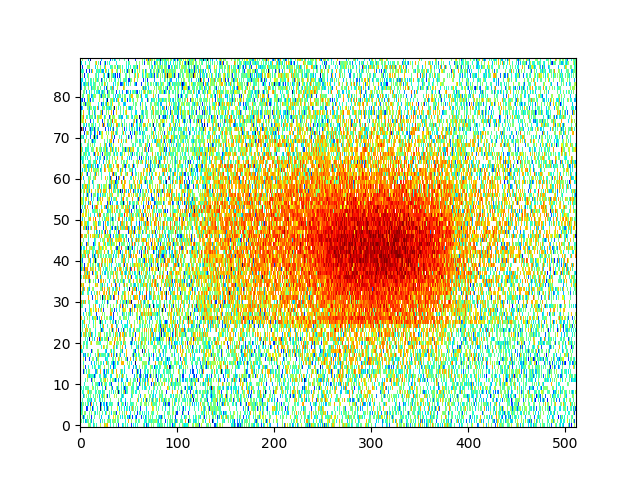

/usr/local/lib/python3.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


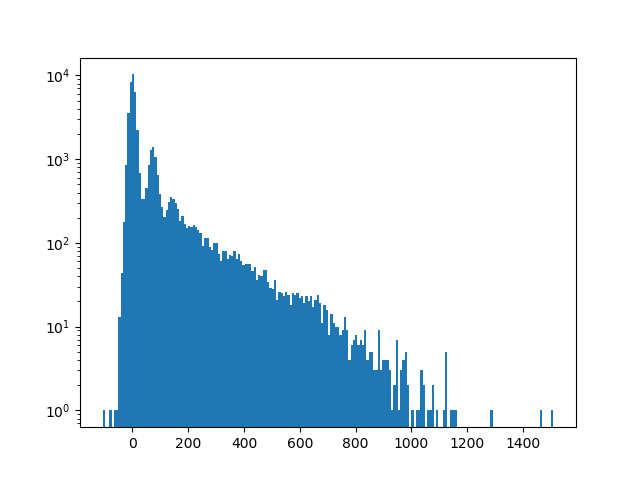

/usr/local/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/usr/local/lib/python3.7/site-packages/ipykernel/__main__.py:20: RuntimeWarning: invalid value encountered in less


In [34]:
i=586390362
i3=where(trainid3==i)
i3=i3[0][0]/250

i4=where(trainid4==i)
i4=i4[0][0]/250

i5=where(trainid5==i)
i5=i5[0][0]/250

i6=where(trainid6==i)
i6=i6[0][0]/250
    
data=array(concatenate((data3[i3,1:17,170:260,:],data4[i4,1:17,230:320,:],data5[i5,1:17,230:320,:],data6[i6,1:17,230:320,:]),axis=2))
figure()
#data[10,:,:]=nan_to_num(data[10,:,:])
imshow(data[1],origin='lower',cmap='jet',norm=mpl.colors.LogNorm(),aspect='auto',vmin=10e-2,vmax=1000)
figure()
hist(data[1].flatten(), bins=200, log=True)
if sum(data[1]<-10000)>10:
    print(sum(data[1]<0))


#    

# 9. Trains check

#    

In [26]:
pulse_train

[586386209,
 586386791,
 586387147,
 586387421,
 586388272,
 586388290,
 586388554,
 586389049,
 586389338,
 586389624,
 586389904,
 586390357,
 586390359,
 586390864,
 586390885,
 586391236]

In [10]:
trainid3=array(trainid3)
trainid4=array(trainid4)
trainid5=array(trainid5)
trainid6=array(trainid6)

In [11]:
good_trains=[]
#586385602, 586391392 for run65
#586395135,586398142 for run 66
for i in range( 586385602, 586391392):
    if (i in trainid3) and (i in trainid4) and (i in trainid5) and (i in trainid6):
        good_trains.append(i)

In [12]:
len(good_trains)

5716

In [11]:
count3=0
count4=0
count5=0
count6=0
print('number of trains for 3 module {},4 module {}, 5 module {}, 6 module {}'.format(len(trainid3)/250,len(trainid4)/250,len(trainid5)/250,len(trainid6)/250))
for i in range(0,len(trainid4),250):
    if i !=0 :
        if (trainid3[i]-trainid3[i-1] >1 ):
            print('3 module lost {} trains: {} train = {} ,{} train = {}'.format(trainid3[i].compute()-trainid3[i-1].compute()-1,(i-250)/250 ,trainid3[i-1].compute(),i/250, trainid3[i].compute()))
            count3+=trainid3[i].compute()-trainid3[i-1].compute()-1
        elif (trainid4[i]-trainid4[i-1] >1):
            print('4 module lost {} trains: {} train = {} ,{} train = {}'.format(trainid4[i].compute()-trainid4[i-1].compute()-1,(i-250)/250 ,trainid4[i-1].compute(),i/250, trainid4[i].compute()))
            count4+=trainid4[i].compute()-trainid4[i-1].compute()-1
        elif (trainid5[i]-trainid5[i-1] >1):
            print('5 module lost {} trains: {} train = {} ,{} train = {}'.format(trainid5[i].compute()-trainid5[i-1].compute()-1,(i-250)/250 ,trainid5[i-1].compute(),i/250, trainid5[i].compute()))
            count5+=trainid5[i].compute()-trainid5[i-1].compute()-1
        elif (trainid6[i]-trainid6[i-1] >1):
            print('6 module lost {} trains: {} train = {} ,{} train = {}'.format(trainid6[i].compute()-trainid6[i-1].compute()-1,(i-250)/250 ,trainid6[i-1].compute(),i/250, trainid6[i].compute()))
            count6+=trainid6[i].compute()-trainid6[i-1].compute()-1
print('last train for 3 module {} 4 module {}, 5 module {}, 6 module {}'.format(trainid3[len(trainid3)-1].compute(),trainid4[len(trainid4)-1].compute(),trainid5[len(trainid5)-1].compute(),trainid6[len(trainid6)-1].compute()))
print('3 module lost {} trains, 4 module lost {} trains, 5 module {} lost trains, 6 module lost {} trains'.format(count3,count4,count5,count6))

number of trains for 3 module 5772.0,4 module 5767.0, 5 module 5775.0, 6 module 5774.0


AttributeError: 'numpy.uint64' object has no attribute 'compute'

In [25]:
sort.index(586390361.0)

82

In [12]:
sort=[]
j=0
for i in pulse_train:
#     a=where(trainid4.compute()==pulse_train[i])
#     mid=int(a[0][0]/250)
    if (i-3 in good_trains) and (i-2 in good_trains) and (i-1 in good_trains) and (i+1 in good_trains) and (i+2 in good_trains) and (i+3 in good_trains):
        print('{} out of {} pulse in good train'.format(j,len(pulse_train)-1))
        sort.append(i-3)
        sort.append(i-2)
        sort.append(i-1)
        sort.append(i)
        sort.append(i+1)
        sort.append(i+2)
        sort.append(i+3)
    j+=1

1 out of 15 pulse in good train
2 out of 15 pulse in good train
3 out of 15 pulse in good train
4 out of 15 pulse in good train
5 out of 15 pulse in good train
6 out of 15 pulse in good train
7 out of 15 pulse in good train
8 out of 15 pulse in good train
9 out of 15 pulse in good train
10 out of 15 pulse in good train
11 out of 15 pulse in good train
12 out of 15 pulse in good train
13 out of 15 pulse in good train
14 out of 15 pulse in good train
15 out of 15 pulse in good train


In [28]:
for i in sort:
    i3=where(trainid3==i)
    i3=i3[0][0]/250

    i4=where(trainid4==i)
    i4=i4[0][0]/250
    
    i5=where(trainid5==i)
    i5=i5[0][0]/250

    i6=where(trainid6==i)
    i6=i6[0][0]/250

    ixgm=where(train_xgm==i)

    print(i3,i4,i5,i6,ixgm[0][0],i)

1182.0 1184.0 1182.0 1182.0 1186 586386788.0
1183.0 1185.0 1183.0 1183.0 1187 586386789.0
1184.0 1186.0 1184.0 1184.0 1188 586386790.0
1185.0 1187.0 1185.0 1185.0 1189 586386791
1186.0 1188.0 1186.0 1186.0 1190 586386792.0
1187.0 1189.0 1187.0 1187.0 1191 586386793.0
1188.0 1190.0 1188.0 1188.0 1192 586386794.0
1537.0 1540.0 1538.0 1538.0 1542 586387144.0
1538.0 1541.0 1539.0 1539.0 1543 586387145.0
1539.0 1542.0 1540.0 1540.0 1544 586387146.0
1540.0 1543.0 1541.0 1541.0 1545 586387147
1541.0 1544.0 1542.0 1542.0 1546 586387148.0
1542.0 1545.0 1543.0 1543.0 1547 586387149.0
1543.0 1546.0 1544.0 1544.0 1548 586387150.0
1811.0 1812.0 1812.0 1812.0 1816 586387418.0
1812.0 1813.0 1813.0 1813.0 1817 586387419.0
1813.0 1814.0 1814.0 1814.0 1818 586387420.0
1814.0 1815.0 1815.0 1815.0 1819 586387421
1815.0 1816.0 1816.0 1816.0 1820 586387422.0
1816.0 1817.0 1817.0 1817.0 1821 586387423.0
1817.0 1818.0 1818.0 1818.0 1822 586387424.0
2659.0 2656.0 2662.0 2662.0 2667 586388269.0
2660.0 2657.0 26

In [13]:
xgm = run.get_array('SA2_XTD1_XGM/XGM/DOOCS:output','data.intensityTD')
train_xgm=run.get_array('SA2_XTD1_XGM/XGM/DOOCS:output','data.trainId')
xgm_x=run.get_array('SA2_XTD1_XGM/XGM/DOOCS:output','data.xTD')
xgm_y=run.get_array('SA2_XTD1_XGM/XGM/DOOCS:output','data.yTD')

In [192]:
a=where(trainid4.compute()==pulse_train[1])
mid=int(a[0][0]/250)

In [198]:
if mid in good_trains:
    print('true')

true


In [189]:
where(trainid4.compute()== 586386209)

array([151250, 151251, 151252, 151253, 151254, 151255, 151256, 151257,
       151258, 151259, 151260, 151261, 151262, 151263, 151264, 151265,
       151266, 151267, 151268, 151269, 151270, 151271, 151272, 151273,
       151274, 151275, 151276, 151277, 151278, 151279, 151280, 151281,
       151282, 151283, 151284, 151285, 151286, 151287, 151288, 151289,
       151290, 151291, 151292, 151293, 151294, 151295, 151296, 151297,
       151298, 151299, 151300, 151301, 151302, 151303, 151304, 151305,
       151306, 151307, 151308, 151309, 151310, 151311, 151312, 151313,
       151314, 151315, 151316, 151317, 151318, 151319, 151320, 151321,
       151322, 151323, 151324, 151325, 151326, 151327, 151328, 151329,
       151330, 151331, 151332, 151333, 151334, 151335, 151336, 151337,
       151338, 151339, 151340, 151341, 151342, 151343, 151344, 151345,
       151346, 151347, 151348, 151349, 151350, 151351, 151352, 151353,
       151354, 151355, 151356, 151357, 151358, 151359, 151360, 151361,
      

/usr/local/lib/python3.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


<IPython.core.display.Javascript object>


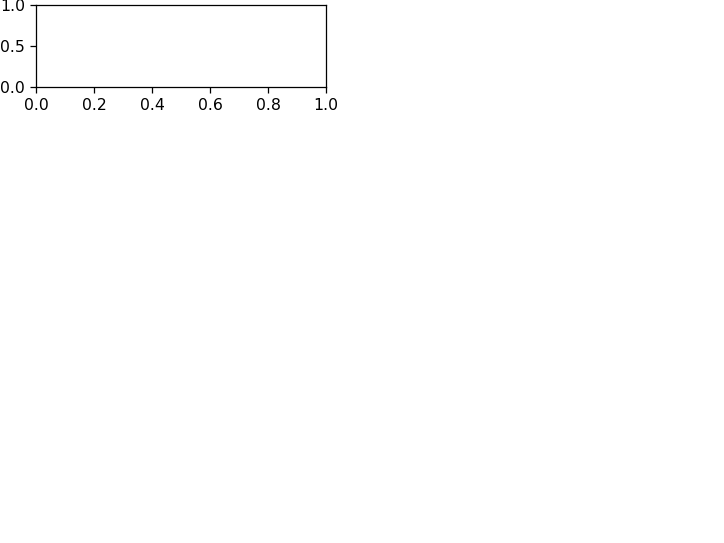

In [87]:
fig = plt.figure()
ax=fig.add_axes([0.05,0.84,0.4,0.15])
ion()
for i in range(0,5):
    ax.plot(correctedData[i])
    pause(0.5)
    fig.canvas.draw()
    ax.cla()

#    

# 9. Save everything in pandas

#    

In [122]:
range(1,20)

range(1, 20)

In [124]:
d={'trainid':trainid4[i].compute(),'pulseN':range(1,20),'cen_x':fluct_x[:,0],'cen_y':fluct_y[:,0],'wid_x':fluct_x[:,2],'wid_y':fluct_y[:,2],'amp_x':fluct_x[:,1],'amp_y':fluct_y[:,1],'xgm_x':xgm_x[i,1:20],'xgm_y':xgm_y[i,1:20],'xgm_amp':xgm[i,1:20]}
    
df = pd.DataFrame(d)

In [116]:
d={'trainid':trainid4[i].compute(),'cen_x':fluct_x[:,0],'cen_y':fluct_y[:,0]}

In [135]:
df.to_csv('run65_positions.csv')

AttributeError: 'int' object has no attribute 'to_csv'

In [3]:
df=pd.read_csv (r'run66_positions.csv',index_col=0) 

In [10]:
df2=pd.read_csv (r'run65_positions_try2.csv',index_col=0) 

In [4]:
df

,trainId,pulseN,cen_x,cen_y,wid_x,wid_y,amp_x,amp_y,cen_xerr,cen_yerr,xgm_x,xgm_y,xgm_amp,B_field,voltage,quality
0,586395281.0,1,0.533992,0.491528,0.026023,0.026920,81.569775,92.391488,0.001316,0.001519,-0.227688,0.740741,312.968000,0.0,0,Good
1,586395281.0,2,0.532793,0.484098,0.027992,0.025717,192.368068,226.460114,0.001077,0.001322,1.195361,-15.359116,325.858280,0.0,0,Good
2,586395281.0,3,0.534252,0.478344,0.028687,0.027175,72.417853,82.685170,0.001336,0.001631,0.364117,-11.111112,323.969850,0.0,0,Good
3,586395281.0,4,0.533447,0.495931,0.028099,0.025948,113.421112,131.412637,0.001206,0.001446,0.002747,-4.112149,272.603820,0.0,0,Good
4,586395281.0,5,0.536118,0.491005,0.033808,0.026141,36.294149,45.237063,0.002087,0.002137,1.748279,-17.333334,305.574600,0.0,0,Good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019,586397636.0,12,0.537635,0.485536,0.024535,0.026928,95.758589,108.180595,0.001139,0.001507,2.323148,2.500000,178.364780,0.0,0,Good
1020,586397636.0,13,0.536401,0.498490,0.030834,0.026471,44.131265,52.057621,0.001727,0.001393,0.732452,9.753694,238.304110,0.0,0,Good
1021,586397636.0,14,0.516993,0.489974,0.039639,0.029749,14.020104,13.844856,0.003218,0.002821,-7.072146,-5.647058,29.197725,0.0,0,Good
1022,586397636.0,15,0.533712,0.494377,0.029182,0.025715,54.235159,62.608828,0.001586,0.001737,-6.749146,-16.431229,16.380058,0.0,0,Good


#    

# 9. Timing check

#    

<IPython.core.display.Javascript object>


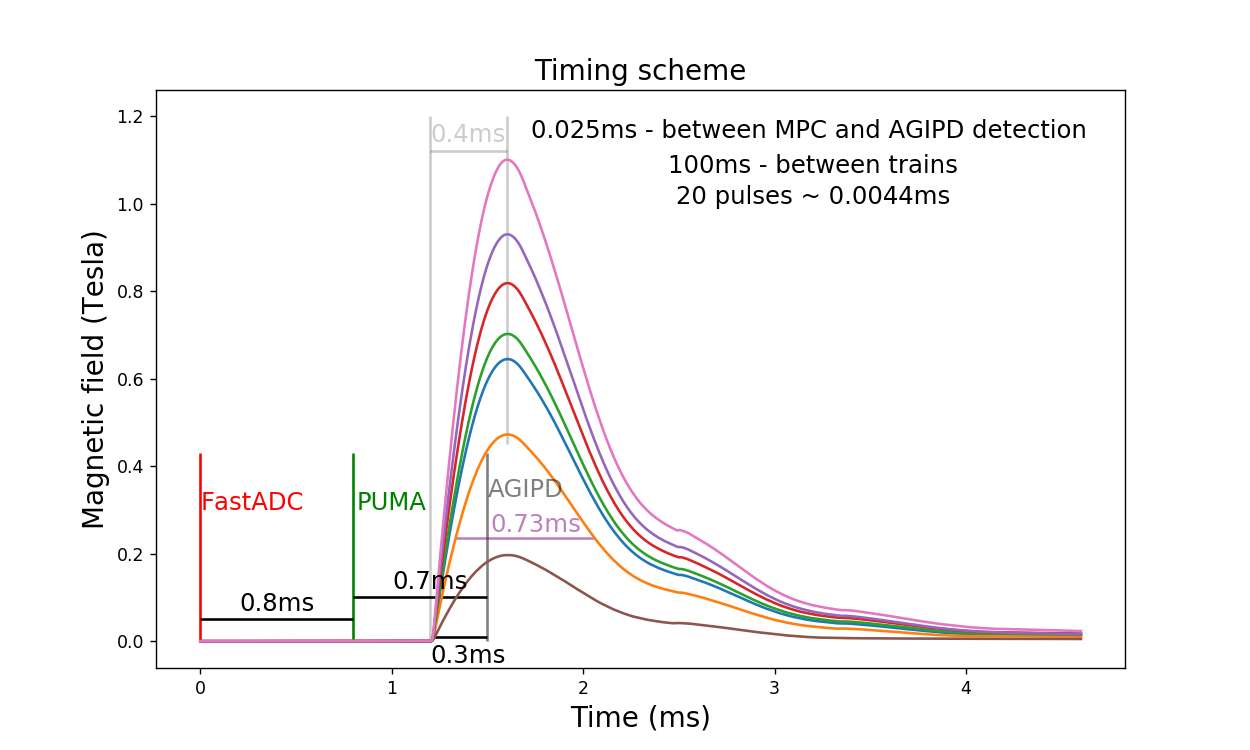

In [38]:
x=linspace(0,len(correctedData[1]),500000)*18.4*1e-6
figure(figsize=(10,6))
plot(x[0:250000],cumsum(correctedData[4][0:250000])*1.84*10e-8/2.65/10e-5)
plot(x[0:250000],cumsum(correctedData[2][0:250000])*1.84*10e-8/2.65/10e-5)
plot(x[0:250000],cumsum(correctedData[6][0:250000])*1.84*10e-8/2.65/10e-5)
plot(x[0:250000],cumsum(correctedData[8][0:250000])*1.84*10e-8/2.65/10e-5)
plot(x[0:250000],cumsum(correctedData[10][0:250000])*1.84*10e-8/2.65/10e-5)
plot(x[0:250000],cumsum(correctedData[12][0:250000])*1.84*10e-8/2.65/10e-5)
plot(x[0:250000],cumsum(correctedData[13][0:250000])*1.84*10e-8/2.65/10e-5)



plt.title('Timing scheme',horizontalalignment='center',size=16)
plt.xlabel('Time (ms)',horizontalalignment='center',size=16)
plt.ylabel('Magnetic field (Tesla)',horizontalalignment='center',size=16)

plt.vlines(x=0,ymin=0, ymax=0.43,color='red')
plt.vlines(x=0.8,ymin=0, ymax=0.43,color='green')
plt.vlines(x=1.5,ymin=0, ymax=0.43,color='black',alpha=0.5)
plt.text(0.27, 0.3, 'FastADC', horizontalalignment='center',color='red',size=14)
plt.text(1, 0.3, 'PUMA', horizontalalignment='center',color='green',size=14)
plt.text(1.7, 0.33, 'AGIPD', horizontalalignment='center',color='black',size=14,alpha=0.5)



plt.hlines(y=0.05,xmin=0, xmax=0.8,color='black')
plt.hlines(y=0.1,xmin=0.8, xmax=1.5,color='black')
plt.text(0.4, 0.07, '0.8ms', horizontalalignment='center',color='black',size=14)
plt.text(1.2, 0.12, '0.7ms', horizontalalignment='center',color='black',size=14)

plt.hlines(y=0.01,xmin=1.21, xmax=1.5,color='black')
plt.text(1.4, -0.05, '0.3ms', horizontalalignment='center',color='black',size=14)


plt.hlines(y=0.4725310489174864/2,xmin=1.33, xmax=2.06,color='purple',alpha=0.5)
plt.text(1.75, 0.25, '0.73ms', horizontalalignment='center',color='purple',alpha=0.5,size=14)

plt.vlines(x=1.6,ymin=0.45, ymax=1.2,color='black',alpha=0.2)
plt.vlines(x=1.2,ymin=0, ymax=1.2,color='black',alpha=0.2)
plt.hlines(y=1.12,xmin=1.2, xmax=1.6,color='black',alpha=0.2)
plt.text(1.4, 1.14, '0.4ms', horizontalalignment='center',color='black',alpha=0.2,size=14)

plt.text(3.2,1.0, '20 pulses ~ 0.0044ms', horizontalalignment='center',color='black',size=14)
plt.text(3.2,1.07, '100ms - between trains', horizontalalignment='center',color='black',size=14)
plt.text(3.2,1.15, '0.025ms - between MPC and AGIPD detection ', horizontalalignment='center',color='black',size=14)


fig.legend()

In [98]:
shape(cumsum(correctedData[13][0:250000])*1.84*10e-8/2.65/10e-5)

(250000,)

/usr/local/lib/python3.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()


<IPython.core.display.Javascript object>


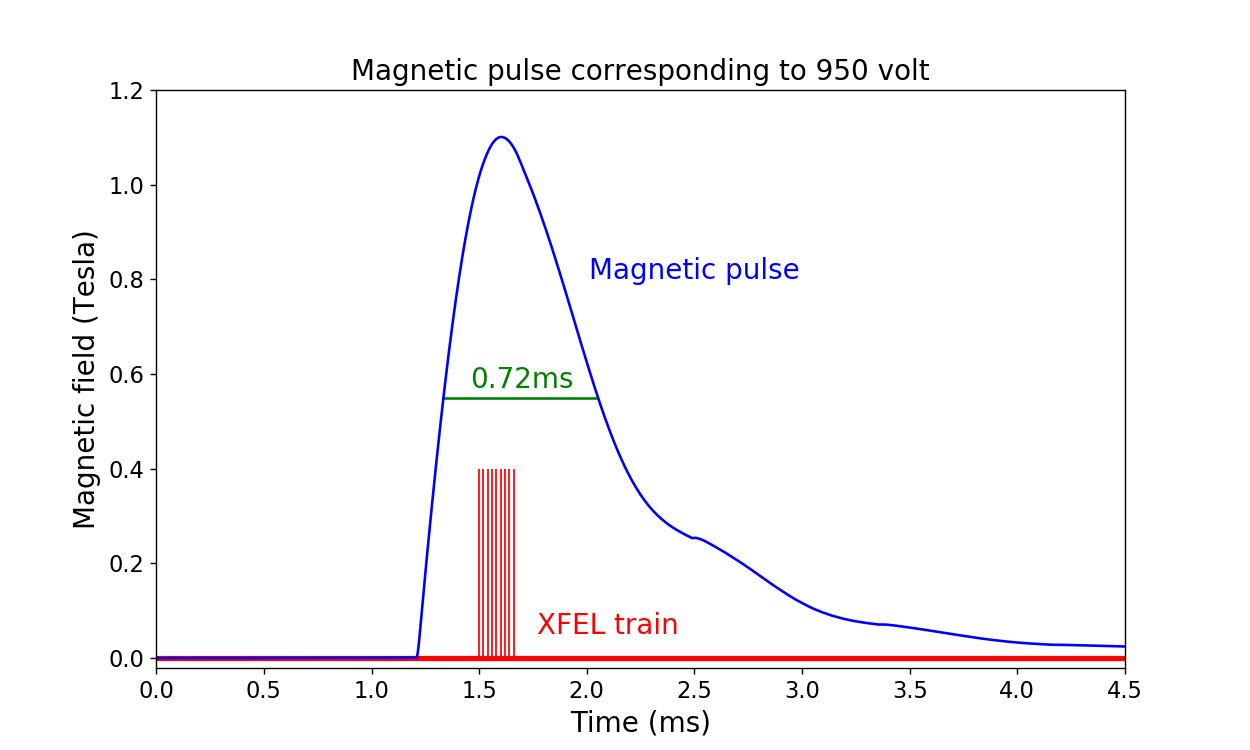

In [129]:
x=linspace(0,len(correctedData[1]),500000)*18.4*1e-6
B=cumsum(correctedData[13][0:250000])*1.84*10e-8/2.65/10e-5
figure(figsize=(10,6))
plot(x[0:250000],B[:],color='blue')

plt.title('Magnetic pulse corresponding to 950 volt',horizontalalignment='center',size=16)
plt.xlabel('Time (ms)',horizontalalignment='center',size=16)
plt.ylabel('Magnetic field (Tesla)',horizontalalignment='center',size=16)

plt.hlines(y=1.1/2,xmin=1.33, xmax=2.05,color='green')
plt.text(1.7, 1.1/2+0.02, '0.72ms', horizontalalignment='center',color='green',size=16)

plt.text(2.5, 0.8, 'Magnetic pulse', horizontalalignment='center',color='blue',size=16)

plt.hlines(y=0,xmin=0, xmax=5,color='red',linewidths=3)
plt.vlines(x=1.5,ymin=0, ymax=0.4,color='red',linewidths=1)
plt.vlines(x=1.52,ymin=0, ymax=0.4,color='red',linewidths=1)
plt.vlines(x=1.54,ymin=0, ymax=0.4,color='red',linewidths=1)
plt.vlines(x=1.56,ymin=0, ymax=0.4,color='red',linewidths=1)
plt.vlines(x=1.58,ymin=0, ymax=0.4,color='red',linewidths=1)
plt.vlines(x=1.60,ymin=0, ymax=0.4,color='red',linewidths=1)
plt.vlines(x=1.62,ymin=0, ymax=0.4,color='red',linewidths=1)
plt.vlines(x=1.64,ymin=0, ymax=0.4,color='red',linewidths=1)
plt.vlines(x=1.66,ymin=0, ymax=0.4,color='red',linewidths=1)

plt.text(2.1, 0.05, 'XFEL train', horizontalalignment='center',color='red',size=16)
plt.xlim((0,4.5))
plt.ylim((-0.02,1.2))
tick_params(labelsize=13)

# fig.legend()

#    

# 10. Plots

#    

In [31]:
df2

,trainId,pulseN,cen_x,cen_y,wid_x,wid_y,amp_x,amp_y,cen_xerr,cen_yerr,xgm_x,xgm_y,xgm_amp,B_field,voltage,quality
0,586386788.0,1,0.569104,0.503294,0.023467,0.025536,82.357863,90.962803,0.001178,0.001652,-1.175142,-9.731800,301.49835,0.0,0,Good
1,586386788.0,2,0.568069,0.503931,0.024360,0.024879,139.351535,153.037389,0.001067,0.001298,0.794116,0.000000,324.13318,0.0,0,Good
2,586386788.0,3,0.568648,0.491660,0.023089,0.024503,318.838312,349.838559,0.000909,0.001241,0.710825,4.927536,277.36816,0.0,0,Good
3,586386788.0,4,0.568454,0.504772,0.023415,0.023559,407.910895,454.772441,0.000873,0.001216,0.043611,0.000000,319.69775,0.0,0,Good
4,586386788.0,5,0.569687,0.492744,0.023374,0.026075,109.720154,118.844028,0.001054,0.001402,0.534699,0.000000,364.85040,0.0,0,Good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1675,586391239.0,12,0.536287,0.489548,0.031713,0.027420,35.862847,39.679929,0.001964,0.001935,1.134629,0.000000,282.22827,0.0,0,Good
1676,586391239.0,13,0.541969,0.487389,0.025280,0.027182,89.645981,100.119570,0.001258,0.001645,0.293245,-8.210526,279.71222,0.0,0,Good
1677,586391239.0,14,0.539672,0.483949,0.025458,0.026453,99.859526,111.002328,0.001212,0.001566,0.287683,-0.913706,203.02328,0.0,0,Good
1678,586391239.0,15,0.543933,0.493178,0.023937,0.026171,165.283952,183.896189,0.001048,0.001491,1.142294,18.513010,256.72470,0.0,0,Good


In [35]:
df2.loc[0]

trainId     5.86387e+08
pulseN                1
cen_x          0.569104
cen_y          0.503294
wid_x         0.0234671
wid_y         0.0255363
amp_x           82.3579
amp_y           90.9628
cen_xerr     0.00117785
cen_yerr     0.00165177
xgm_x          -1.17514
xgm_y           -9.7318
xgm_amp         301.498
B_field               0
voltage               0
quality            Good
Name: 0, dtype: object